Datos:

- regiones y comunas http://www.subdere.gov.cl/documentacion/c%C3%B3digos-%C3%BAnicos-territoriales-actualizados-al-06-de-septiembre-2018

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import seaborn as sn
import scipy
import numpy as np
import plotly.express as px
from statsmodels.distributions.empirical_distribution import ECDF

import sys
sys.path.append("../")
from plots import marginal_dependency_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
def get_gini(x):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq: http://www.statsdirect.com/help/content/image/stat0206_wmf.gif
    # from: http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    array = x.values.flatten() #all values are treated equally, arrays must be 1d
    if np.amin(array) < 0:
        array -= np.amin(array) #values cannot be negative
    array += 0.0000001 #values cannot be 0
    array = np.sort(array) #values must be sorted
    index = np.arange(1,array.shape[0]+1) #index per array element
    n = array.shape[0]#number of array elements
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array))) #Gini coefficient


In [24]:
ls ../datos/

datos_procesados.csv  estudio_fundacion_sol.pdf   region_comuna.csv
esi-2019.csv          guia-personas-esi-2019.pdf


In [25]:
path = "../datos/"
esi = pd.read_csv(path+"esi-2019.csv", sep=';', encoding='latin')
region_comuna = pd.read_csv(path+"region_comuna.csv", sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (37,77,129,130,132,137,142,147,152,156,158,162,166,170,174,178,182,183,186,187,192,198,202,203,208,209,211,212,217,218,219,221,222,223,224,228,229,240,243,246,249,250,253,256,259,262,265,266,269,272,273,276,277,280,281,284,287,288,289,292,295,296,297) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [26]:
cols_monto = ['d1_monto'] + [c for c in esi.columns if c.startswith('d') and 'monto' in c]

In [29]:
path = "../datos/"
esi = pd.read_csv(path+"esi-2019.csv", sep=';', encoding='latin')
region_comuna = pd.read_csv(path+"region_comuna.csv", sep=';')

esi = pd.merge(esi, region_comuna, left_on='r_p_c', right_on='Código Comuna 2018', how='left')
esi.drop(['region'], axis=1, inplace=True)

columns_map = {
    'id_identificacion': 'id_hogar',
    'idrph': 'id_persona',
    'tipo': 'tipo_zona',
    't_muestra': 'tipo_muestra',
    'd1_monto': 'sueldo_neto',
    'Nombre Región': 'region',
    'Nombre Provincia': 'provincia',
    'Nombre Comuna': 'comuna',
    'b1': 'grupo_ocupacion',
    'cise': 'categoria_empleo',
    'b8': 'tiene_contrato',
    'b12': 'est_subcontratado',
    'b13_rev4cl_caenes': 'rubro',
    'c1': 'tipo_jornada',
    'parentesco': 'rol_hogar',
    'nivel': 'nivel_educacional',
    'b15_1': 'rango_personas_en_empresa',
    'b15_2': 'personas_en_empresa',
}

esi = esi.rename(columns=columns_map)

values_map = {
    'rol_hogar': {
        1: 'Jefe de hogar',
        2: 'Cónyuge',
        3: 'Conviviente',
        4: 'Hijo(a) / Hijastro(a)',
        5: 'Yerno / Nuera',
        6: 'Nieto(a)',
        7: 'Hermano(a) / Cuñado(a)',
        8: 'Padres / Suegros',
        9: 'Otro pariente',
        10: 'No pariente',
        11: 'Servicio doméstico',
        12: 'Fuera del hogar',
        13: 'Fallecido',
    }
    ,
    
    'nivel_educacional': {
        0: 'Nunca estudió',
        1: 'Sala cuna',
        2: 'Kínder',
        3: 'Básica o primaria 4 Media común',
        5: 'Media técnico profesional 6 Humanidades',
        7: 'Centro formación técnica 8 Instituto profesional',
        9: 'Universitario 10 Postítulo',
        11: 'Magíster',
        12: 'Doctorado',
        14: 'Normalista',
        99: 'Nivel ignorado',
        999: 'Nivel ignorado',
    }
    ,
    
    'tipo_zona': {
        1: 'Ciudad',
        2: 'Resto area urbana',
        3: 'Rural'
    }
    ,
    
    'sexo': {
        1: 'Hombre',
        2: 'Mujer'
    }
    ,
    
    'termino_nivel': {
        1: "Si",
        2: "No"
    }
    ,
    
    'cine': {
        1: "Nunca estudió",
        2: "Educación preescolar",
        3: 'Educación primaria (nivel 1)',
        4: 'Educación primaria (nivel 2)',
        5: 'Educación secundaria',
        6: 'Educación técnica',
        7: 'Educación universitaria',
        8: 'Postítulo y maestría',
        9: 'Doctorado',
        999: None
    }
    ,
    
    'est_conyugal': {
        0: None,
        1: "Casade",
        2: "Coviviente",
        3: "Soltere",
        4: "Viude",
        5: "Separade",
        6: "Divorciade"
    }
    ,
    
    'categoria_empleo': {
        0: None,
        1: 'Empleador',
        2: 'Cuenta propia',
        3: 'Asalariado sector privado',
        4: 'Asalariado sector público',
        5: 'Personal de servicio doméstico puertas afuera',
        6: 'Personal de servicio doméstico puertas adentro',
        7: 'Familiar o personal no remunerado'
    }
    ,
    
    'grupo_ocupacion': {
        1: 'Directores, gerentes y administradores',
        2: 'Profesionales, cientificos e intelectuales',
        3: 'Tecnicos y profesionales de nivel medio',
        4: 'Personal de apoyo administrativo',
        5: 'Trabajadores de los servicios y vendedores de comercios y mercados',
        6: 'Agricultores y trabajadores calificados agropecuarios, forestales y pesqueros',
        7: 'Artesanos y operarios de oficios',
        8: 'Operadores de instalaciones, máquinas y ensambladores',
        9: 'Ocupaciones elementales',
        10: None
    }
    ,
    
    'est_subcontratado': {
        1: 'Contrato',
        2: 'Subcontrato'
    }
    ,
    
    'tipo_jornada': {
        1: 'Completa',
        2: 'Parcial'
    }
    ,
    
    'personas_en_empresa': {
        1: 'Menos de 5',
        2: 'De 5 a 10 personas',
        3: 'Entre 11 y 49',
        4: 'Entre 50 y 199',
        5: '200 y más personas'
    }
    ,
    
    'nacionalidad': {
        0: 'Chile',
        20052: 'Venezuela',
        20042: 'Perú',
        20027: 'Haití',
        20010: 'Bolivia',
        20014: 'Colombia',
        20004: 'Argentina',
        20018: 'Ecuador'
    }
    
   
}


for variable, mapping in values_map.items():
    esi[variable] = esi[variable].map(mapping)
    
def procesar_monto(x):
    try:
        if ',' in x:
            x = x.replace(',', '.')
        return float(x)
    except:
        return x

#for c in cols_monto:
#    esi[c] = esi[c].apply(procesar_monto)
esi['sueldo_neto'] = esi['sueldo_neto'].apply(procesar_monto)
cols_monto = ['sueldo_neto']
esi.dropna(subset=cols_monto, how='all', inplace=True)
sueldo_col_name = 'sueldo_neto'

In [17]:
esi['sueldo'] = esi[cols_monto].sum(axis=1)
esi = esi.query('sueldo_neto > 0')

UndefinedVariableError: name 'sueldo_neto' is not defined

In [18]:
esi.sueldo.mean()

501257.4960603205

In [19]:
esi.query('a6 == 1')['sueldo'].mean()

1566932.7347756631

In [20]:
esi.query('a2 == 1')['sueldo'].median()

184068.90382928943

In [39]:
edad_bins = [0, 18, 30, 59, 60, 100]

In [45]:
numerical_features = [
    'edad', 'meses_empleo'
]

categorical_features = [
    'sexo', 'rol_hogar', 'tipo_zona', 
    'termino_nivel', 'cine', 'est_conyugal', 'region', 'comuna', 'provincia',
    'est_subcontratado', 'categoria_empleo', 'grupo_ocupacion', 'nacionalidad'
]

target = 'sueldo_neto'
esi.dropna(subset=[sueldo_col_name], inplace=True)
esi['meses_empleo'] = esi['meses_empleo'].astype(int)
esi['nacionalidad'] = esi['nacionalidad'].fillna('Otra')

esi[categorical_features] = esi[categorical_features].fillna(value='Missing')
esi['rango_edad'] = pd.cut(esi['edad'], bins=edad_bins)
esi = esi[numerical_features+categorical_features+['rango_edad', target]]
esi[categorical_features] = esi[categorical_features].astype('str')
esi = esi.query(f"{sueldo_col_name} > 0")
esi.to_csv('../datos/datos_procesados.csv')

In [108]:
esi['categoria_empleo'].unique()

array(['Asalariado sector privado', 'Asalariado sector público',
       'Personal de servicio doméstico puertas afuera',
       'Personal de servicio doméstico puertas adentro'], dtype=object)

In [95]:
cum_pct = esi['nacionalidad'].value_counts(dropna=False).cumsum()/esi['nacionalidad'].value_counts().sum()
total = esi['nacionalidad'].value_counts(dropna=False)
pd.merge(cum_pct.to_frame('cum_pct'), total.to_frame('total'), left_index=True, right_index=True)

,cum_pct,total
Chile,0.953770,27893
Venezuela,0.967618,405
Perú,0.975517,231
Haití,0.982356,200
Bolivia,0.988340,175
Colombia,0.993640,155
Otra,0.997914,125
Argentina,0.999008,32
Ecuador,1.000000,29


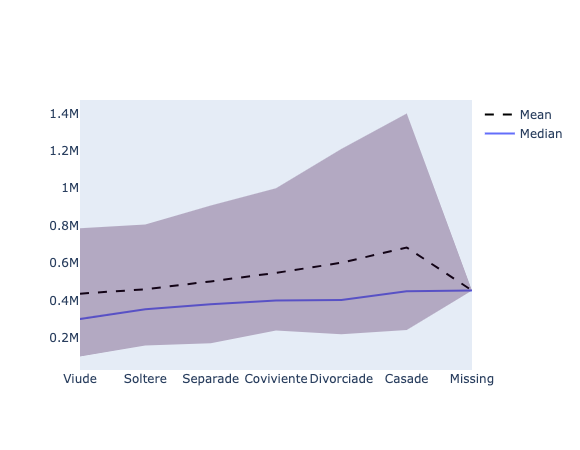

In [97]:
marginal_dependency_plot(esi, sueldo_col_name, 'est_conyugal', is_categorical=True, categories_recall_pct=1)

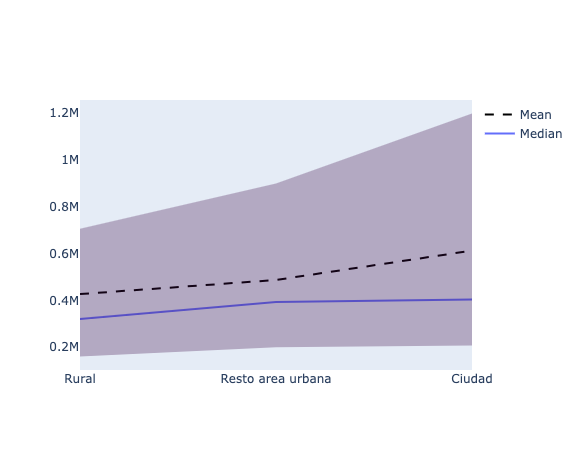

In [99]:
marginal_dependency_plot(esi, sueldo_col_name, 'tipo_zona', is_categorical=True, categories_recall_pct=1)

[(27.15, 31.2], (14.919, 19.05], (31.2, 35.25], (23.1, 27.15], (55.5, 59.55], ..., (75.75, 79.8], (79.8, 83.85], (87.9, 91.95], (83.85, 87.9], (91.95, 96.0]]
Length: 20
Categories (20, interval[float64]): [(14.919, 19.05] < (19.05, 23.1] < (23.1, 27.15] < (27.15, 31.2] ... (79.8, 83.85] < (83.85, 87.9] < (87.9, 91.95] < (91.95, 96.0]]
(14.919, 19.05]
(19.05, 23.1]
(23.1, 27.15]
(27.15, 31.2]
(31.2, 35.25]
(35.25, 39.3]
(39.3, 43.35]
(43.35, 47.4]
(47.4, 51.45]
(51.45, 55.5]
(55.5, 59.55]
(59.55, 63.6]
(63.6, 67.65]
(67.65, 71.7]
(71.7, 75.75]
(75.75, 79.8]
(79.8, 83.85]
(83.85, 87.9]
(87.9, 91.95]
(91.95, 96.0]
dict_values(['15 a 19', '20 a 23', '24 a 27', '28 a 31', '32 a 35', '36 a 39', '40 a 43', '44 a 47', '48 a 51', '52 a 55', '56 a 59', '60 a 63', '64 a 67', '68 a 71', '72 a 75', '76 a 79', '80 a 83', '84 a 87', '90 a 91', '96'])


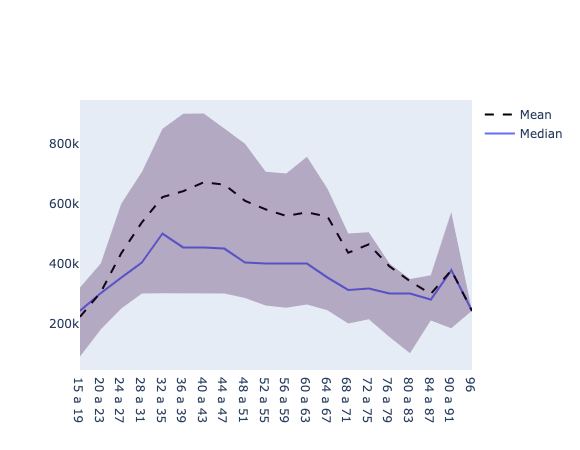

In [17]:
marginal_dependency_plot(esi, sueldo_col_name, 'edad', lower_q=.2, upper_q=.8, is_categorical=False, categories_recall_pct=1, bins=20);

[(0.281, 36.95], (144.8, 180.75], (72.9, 108.85], (180.75, 216.7], (36.95, 72.9], ..., (504.3, 540.25], (684.05, 720.0], (612.15, 648.1], (540.25, 576.2], (648.1, 684.05]]
Length: 20
Categories (20, interval[float64]): [(0.281, 36.95] < (36.95, 72.9] < (72.9, 108.85] < (108.85, 144.8] ... (576.2, 612.15] < (612.15, 648.1] < (648.1, 684.05] < (684.05, 720.0]]
(0.281, 36.95]
(36.95, 72.9]
(72.9, 108.85]
(108.85, 144.8]
(144.8, 180.75]
(180.75, 216.7]
(216.7, 252.65]
(252.65, 288.6]
(288.6, 324.55]
(324.55, 360.5]
(360.5, 396.45]
(396.45, 432.4]
(432.4, 468.35]
(468.35, 504.3]
(504.3, 540.25]
(540.25, 576.2]
(576.2, 612.15]
(612.15, 648.1]
(648.1, 684.05]
(684.05, 720.0]
dict_values(['1.0 a 36.0', '37.0 a 72.0', '73.0 a 108.0', '109.0 a 144.0', '145.0 a 180.0', '181.0 a 216.0', '217.0 a 252.0', '253.0 a 288.0', '289.0 a 324.0', '325.0 a 360.0', '361.0 a 396.0', '397.0 a 432.0', '435.0 a 468.0', '469.0 a 504.0', '505.0 a 540.0', '542.0 a 576.0', '587.0 a 610.0', '622.0 a 648.0', '652.0 a 6

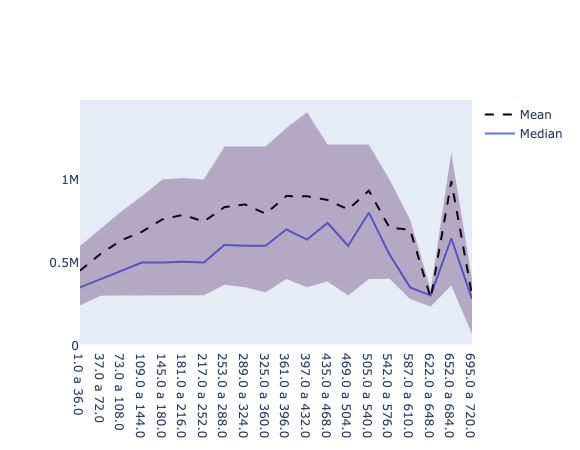

In [18]:
marginal_dependency_plot(esi, sueldo_col_name, 'meses_empleo', lower_q=.2, upper_q=.8, is_categorical=False, categories_recall_pct=1, bins=20);

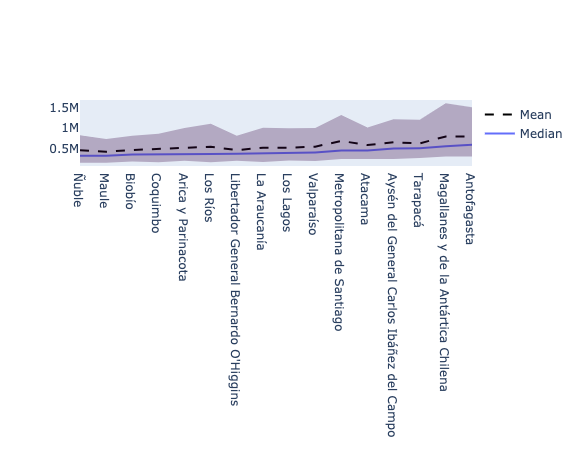

In [12]:
marginal_dependency_plot(esi, sueldo_col_name, 'region', is_categorical=True, categories_recall_pct=1)

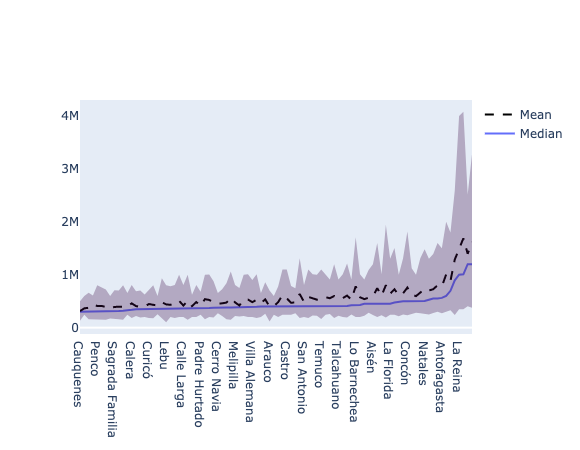

In [13]:
marginal_dependency_plot(esi, sueldo_col_name, 'comuna', is_categorical=True, categories_recall_pct=.8)

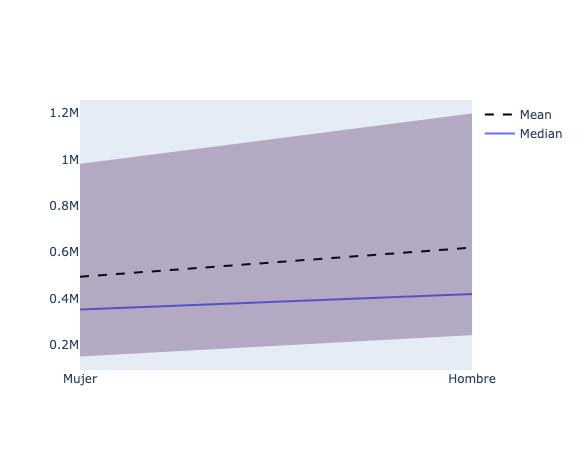

In [14]:
marginal_dependency_plot(esi, sueldo_col_name, 'sexo', is_categorical=True, categories_recall_pct=1)

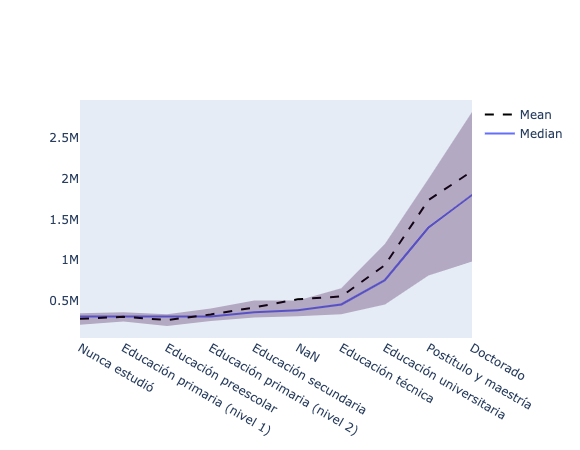

In [15]:
marginal_dependency_plot(esi, sueldo_col_name, 'cine', lower_q=.25, upper_q=.75, is_categorical=True)

In [130]:
pd.cut(esi[sueldo_col_name], 20)

0                             NaN
1         (-13130.848, 656542.38]
2                             NaN
3                             NaN
4        (656542.38, 1313084.761]
                   ...           
96235                         NaN
96236                         NaN
96237    (656542.38, 1313084.761]
96238                         NaN
96239                         NaN
Name: sueldo_neto, Length: 96240, dtype: category
Categories (20, interval[float64]): [(-13130.848, 656542.38] < (656542.38, 1313084.761] < (1313084.761, 1969627.141] < (1969627.141, 2626169.522] ... (10504678.088, 11161220.468] < (11161220.468, 11817762.849] < (11817762.849, 12474305.229] < (12474305.229, 13130847.61]]

In [135]:
bins = 20
feature_series = esi[sueldo_col_name]
feature_values = feature_series.to_frame('feature')
feature_values['feature_bin'] = pd.cut(feature_values['feature'], bins=bins)

0         True
1        False
2         True
3         True
4        False
         ...  
96235     True
96236     True
96237    False
96238     True
96239     True
Name: feature, Length: 96240, dtype: bool

[NaN, (-13130.848, 1313084.761], (1313084.761, 2626169.522], (3939254.283, 5252339.044], (2626169.522, 3939254.283], ..., (10504678.088, 11817762.849], (7878508.566, 9191593.327], (6565423.805, 7878508.566], (9191593.327, 10504678.088], (11817762.849, 13130847.61]]
Length: 11
Categories (10, interval[float64]): [(-13130.848, 1313084.761] < (1313084.761, 2626169.522] < (2626169.522, 3939254.283] < (3939254.283, 5252339.044] ... (7878508.566, 9191593.327] < (9191593.327, 10504678.088] < (10504678.088, 11817762.849] < (11817762.849, 13130847.61]]
(-13130.848, 1313084.761]
(1313084.761, 2626169.522]
(2626169.522, 3939254.283]
(3939254.283, 5252339.044]
(5252339.044, 6565423.805]
(6565423.805, 7878508.566]
(7878508.566, 9191593.327]
(9191593.327, 10504678.088]
(10504678.088, 11817762.849]
(11817762.849, 13130847.61]
dict_values(['0.0 a 1310640.16369482', '1330803.8585209 a 2621280.32738965', '2697914.0 a 3931920.49108447', '3996909.0 a 5040923.70651855', '5300000.0 a 6300000.0', '6594901.01

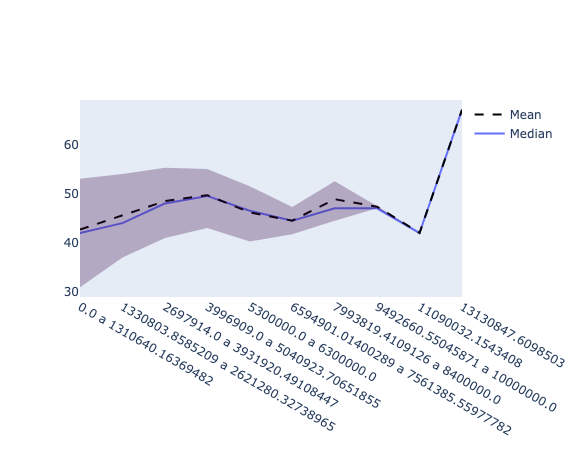

In [143]:
marginal_dependency_plot(esi, 'edad', sueldo_col_name, lower_q=.25, upper_q=.75, is_categorical=False, bins=10)

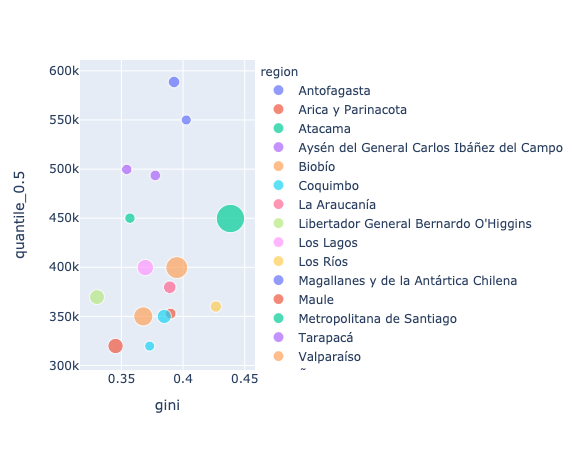

In [14]:
groupby_col = "region"
quantile_value = 0.5

size = esi.dropna(subset=[sueldo_col_name])[groupby_col].value_counts(normalize=True).to_frame('size').reset_index().rename(columns={'index': groupby_col})
gini = esi.dropna(subset=[sueldo_col_name]).groupby([groupby_col])[sueldo_col_name].apply(get_gini).to_frame('gini').reset_index()
quantile = esi.dropna(subset=[sueldo_col_name]).groupby([groupby_col])[sueldo_col_name].apply(np.quantile, q=quantile_value).to_frame(f'quantile_{quantile_value}').reset_index()
summary = pd.merge(gini, quantile, on=groupby_col)
summary = pd.merge(summary, size, on=groupby_col)
px.scatter(summary, x="gini", y=f'quantile_{quantile_value}', color=groupby_col, size='size')                                                                                          
                                                                                           

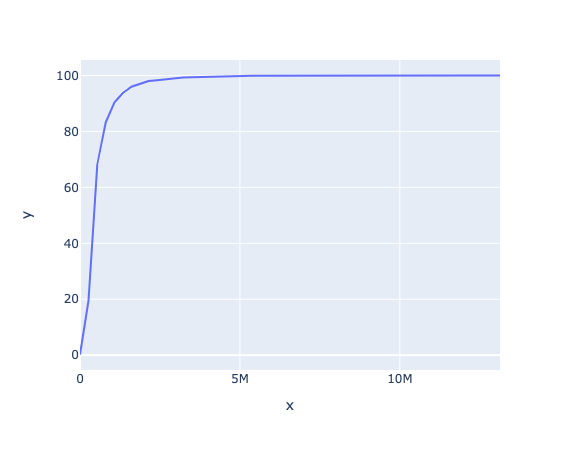

In [15]:

cdf_function = ECDF(esi[sueldo_col_name].dropna().values)
sueldo_range = np.linspace(0, esi[sueldo_col_name].max())
fig = px.line(x=sueldo_range, y=100*cdf_function(sueldo_range))
fig.show()

In [16]:
grid_step = 0.5 # 0.5% de los datos
quantile_list = np.arange(0, 100+grid_step, grid_step)

def get_cdf(x):
    cdf_function = ECDF(x)
    return 100*cdf_function(sueldo_range)

def get_quantile_func(x):
    quantile_function = np.quantile(x, q=quantile_list/100)
    return quantile_function

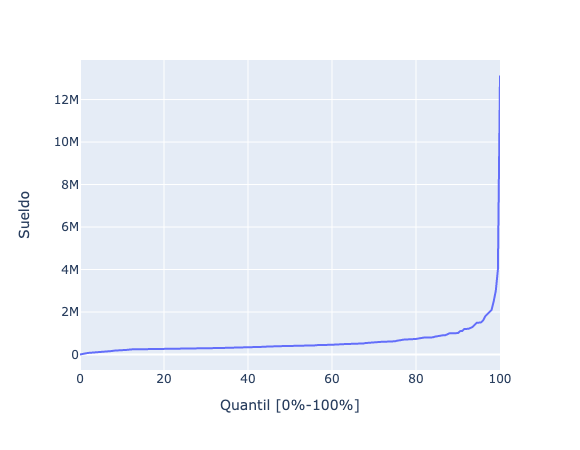

In [17]:
quantile_function = np.quantile(esi[sueldo_col_name].dropna().values, q=quantile_list/100)
px.line(x=quantile_list, y=quantile_function, 
        labels={"x": "Quantil [0%-100%]",
                "y": "Sueldo",
                 }
       )

In [195]:
sueldo_col_name = 'sueldo_neto'
groupby_col = 'region'
max_n_groups = 1000
#max_sueldo = esi[sueldo_col_name].max()
max_sueldo = 2_000_000

nro_datos_grupo = esi.dropna(subset=[sueldo_col_name])[groupby_col].value_counts()
grupos_a_usar = list(nro_datos_grupo.index[:max_n_groups].values)

restriccion = esi.dropna(subset=[sueldo_col_name])[groupby_col].isin(grupos_a_usar)
quantile_dict = esi.dropna(subset=[sueldo_col_name]).loc[restriccion].groupby(groupby_col)[sueldo_col_name].apply(get_quantile_func).to_dict()
quantile_df = pd.DataFrame(quantile_dict, index=quantile_list).reset_index().rename(columns={'index': 'Quantil [0%-100%]'})
quantile_df = quantile_df.melt(id_vars=['Quantil [0%-100%]'], var_name=groupby_col, value_name='Sueldo')
px.line(quantile_df, x='Quantil [0%-100%]', y='Sueldo', color=groupby_col)

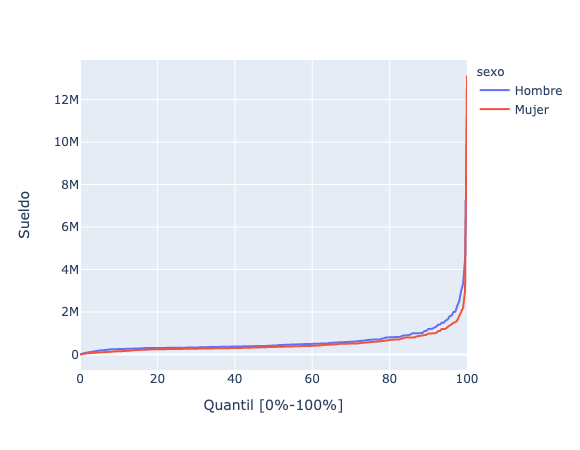

In [11]:
sueldo_col_name = 'sueldo_neto'
groupby_col = 'sexo'
max_n_groups = 1000
#max_sueldo = esi[sueldo_col_name].max()
max_sueldo = 2_000_000

nro_datos_grupo = esi.dropna(subset=[sueldo_col_name])[groupby_col].value_counts()
grupos_a_usar = list(nro_datos_grupo.index[:max_n_groups].values)

restriccion = esi.dropna(subset=[sueldo_col_name])[groupby_col].isin(grupos_a_usar)
quantile_dict = esi.dropna(subset=[sueldo_col_name]).loc[restriccion].groupby(groupby_col)[sueldo_col_name].apply(get_quantile_func).to_dict()
quantile_df = pd.DataFrame(quantile_dict, index=quantile_list).reset_index().rename(columns={'index': 'Quantil [0%-100%]'})
quantile_df = quantile_df.melt(id_vars=['Quantil [0%-100%]'], var_name=groupby_col, value_name='Sueldo')
px.line(quantile_df, x='Quantil [0%-100%]', y='Sueldo', color=groupby_col)

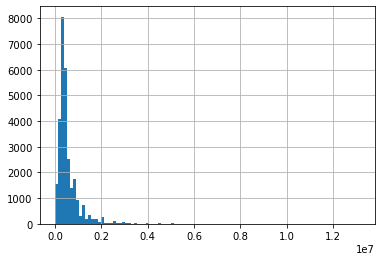

In [28]:
esi['sueldo_neto'].hist(bins=100)

In [24]:
sueldo_col_name = 'sueldo_neto'
groupby_col = 'region'
max_n_groups = 10
#max_sueldo = esi[sueldo_col_name].max()
max_sueldo = 2_000_000

sueldo_range = np.linspace(0, max_sueldo, 1000)

nro_datos_grupo = esi.dropna(subset=[sueldo_col_name])[groupby_col].value_counts()
grupos_a_usar = list(nro_datos_grupo.index[:max_n_groups].values)

restriccion = esi.dropna(subset=[sueldo_col_name])[groupby_col].isin(grupos_a_usar)
cdf_dict = esi.dropna(subset=[sueldo_col_name]).loc[restriccion].groupby(groupby_col)[sueldo_col_name].apply(get_cdf).to_dict()
cdf_df = pd.DataFrame(cdf_dict, index=sueldo_range).reset_index().rename(columns={'index': 'sueldo'})
cdf_df = cdf_df.melt(id_vars=['sueldo'], var_name=groupby_col, value_name='cdf')
px.line(cdf_df, x='sueldo', y='cdf', color=groupby_col)

NameError: name 'get_cdf' is not defined

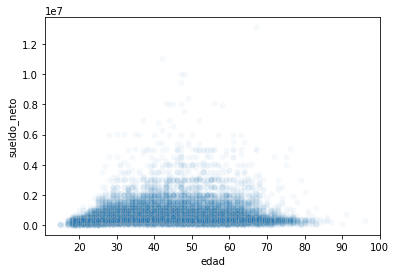

In [143]:
sn.scatterplot(data=esi, x='edad', y='sueldo_neto', alpha=0.04)

In [105]:
esi.nivel

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
96235    NaN
96236    NaN
96237    NaN
96238    NaN
96239    NaN
Name: nivel, Length: 96240, dtype: object

In [111]:
esi.groupby(['nivel']).sueldo_neto.mean().sort_values(ascending=False).to_frame().reset_index().head(20)

,nivel,sueldo_neto
0,Doctorado,2.093541e+06
1,Magíster,1.764538e+06
2,Universitario 10 Postítulo,9.257243e+05
3,Centro formación técnica 8 Instituto profesional,5.323213e+05
4,Normalista,4.611685e+05
5,Media técnico profesional 6 Humanidades,4.584646e+05
6,Nivel ignorado,3.738673e+05
7,Básica o primaria 4 Media común,3.152666e+05
8,Nunca estudió,2.722647e+05
9,Kínder,2.571856e+05


In [140]:
esi.groupby(['parentesco']).sueldo_neto.median().sort_values(ascending=False).to_frame().reset_index().head(20)

,parentesco,sueldo_neto
0,Servicio doméstico,436759.719380
1,Jefe de hogar,430000.000000
2,Cónyuge,400000.000000
3,Yerno / Nuera,399690.970546
4,Conviviente,399690.970546
5,Hijo(a) / Hijastro(a),352864.659456
6,No pariente,349729.599227
7,Hermano(a) / Cuñado(a),349729.599227
8,Otro pariente,320000.000000
9,Padres / Suegros,302455.422391


In [124]:
esi.groupby(['region', 'comuna']).sueldo_neto.median().sort_values(ascending=False).to_frame().reset_index().head(20)

,region,comuna,sueldo_neto
0,Metropolitana de Santiago,Vitacura,1.199536e+06
1,Metropolitana de Santiago,Providencia,1.199073e+06
2,Metropolitana de Santiago,Las Condes,1.008185e+06
3,Metropolitana de Santiago,La Reina,1.000000e+06
4,Metropolitana de Santiago,Ñuñoa,8.946520e+05
5,Valparaíso,El Tabo,8.263950e+05
6,Antofagasta,Calama,6.956475e+05
7,Metropolitana de Santiago,San Miguel,6.049108e+05
8,Atacama,Huasco,6.049108e+05
9,Metropolitana de Santiago,Recoleta,6.000000e+05


In [ ]:
esi